Here I run the entire program without adding any adhesion at all. 
I will then try to add adhesion to where the derivative of the contact forces was positive, as in the other scenario the fact that adding adhesion affected the contact forces was counter productive. 

In [1]:
import os
os.getcwd()
os.chdir('../')


In [2]:
os.getcwd()

'c:\\Users\\lschwitt\\flygym_adhesion-Laetitia'

In [3]:
#pip install -e ."[mujoco]

In [4]:
import numpy as np
import pkg_resources
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo
from tqdm import trange
from flygym.util.config import all_leg_dofs

In [5]:

# Initialize simulation
run_time = 1
nmf = NeuroMechFlyMuJoCo(render_mode='headless', #no graphic rendering: headless, rendering = 'saved'
                         timestep=1e-4,
                         #render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left_top'},
                         init_pose='stretch',
                         actuated_joints=all_leg_dofs,
                         adhesion = False,
                         actuators_adhesion_gain = 4000,#at 20500 it flies away, at 21000 it stays
                         actuated_bodies='all')


[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="4000"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="4000"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="4000"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="4000"/>] actuators _adhesion


In [6]:
"""
# Initialize simulation

#out_dir = Path('../CPGs')

friction = 1.0

physics_config = {
    'joint_stiffness': 2500,
    'friction': (friction, 0.005, 0.0001),
    'gravity': (0, 0, -9.81e5)}
terrain_config = {'fly_pos': (0, 0, 300),
                  'friction': (friction, 0.005, 0.0001)}

nmf = NeuroMechFlyMuJoCo(render_mode='saved',
                         timestep=1e-4,
                         render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left'},
                         init_pose='stretch',
                         actuated_joints=all_leg_dofs)


"""


"\n# Initialize simulation\n\n#out_dir = Path('../CPGs')\n\nfriction = 1.0\n\nphysics_config = {\n    'joint_stiffness': 2500,\n    'friction': (friction, 0.005, 0.0001),\n    'gravity': (0, 0, -9.81e5)}\nterrain_config = {'fly_pos': (0, 0, 300),\n                  'friction': (friction, 0.005, 0.0001)}\n\nnmf = NeuroMechFlyMuJoCo(render_mode='saved',\n                         timestep=1e-4,\n                         render_config={'playspeed': 0.1, 'camera': 'Animat/camera_left'},\n                         init_pose='stretch',\n                         actuated_joints=all_leg_dofs)\n\n\n"

In [7]:
# Load recorded data
data_path = Path(pkg_resources.resource_filename('flygym', 'data'))
#with open(data_path / 'behavior' / '210902_pr_fly1.pkl', 'rb') as f:
#    data = pickle.load(f)
with open(data_path / 'behavior' / 'tripod_engineered.pkl', 'rb') as f:
    data = pickle.load(f)

In [8]:
print('Dict keys:', data.keys())
print('Length of time series:', len(data['joint_RFCoxa']))
print('Metadata:', data['meta'])
print(2000*0.0005) # 1 second! 

Dict keys: dict_keys(['meta', 'joint_LFCoxa', 'joint_LFCoxa_roll', 'joint_LFCoxa_yaw', 'joint_LFFemur', 'joint_LFFemur_roll', 'joint_LFTibia', 'joint_LFTarsus1', 'joint_LMCoxa', 'joint_LMCoxa_roll', 'joint_LMCoxa_yaw', 'joint_LMFemur', 'joint_LMFemur_roll', 'joint_LMTibia', 'joint_LMTarsus1', 'joint_LHCoxa', 'joint_LHCoxa_roll', 'joint_LHCoxa_yaw', 'joint_LHFemur', 'joint_LHFemur_roll', 'joint_LHTibia', 'joint_LHTarsus1', 'joint_RFCoxa', 'joint_RFCoxa_roll', 'joint_RFCoxa_yaw', 'joint_RFFemur', 'joint_RFFemur_roll', 'joint_RFTibia', 'joint_RFTarsus1', 'joint_RMCoxa', 'joint_RMCoxa_roll', 'joint_RMCoxa_yaw', 'joint_RMFemur', 'joint_RMFemur_roll', 'joint_RMTibia', 'joint_RMTarsus1', 'joint_RHCoxa', 'joint_RHCoxa_roll', 'joint_RHCoxa_yaw', 'joint_RHFemur', 'joint_RHFemur_roll', 'joint_RHTibia', 'joint_RHTarsus1'])
Length of time series: 12780
Metadata: {'timestep': 0.0001, 'source': 'Analyze_step_data.ipynb'}
1.0


In [9]:
run_time = len(data['joint_RFCoxa'])*nmf.timestep

num_steps_base = int(run_time / nmf.timestep)

In [10]:
# Interpolate 5x recording 
num_steps = int(run_time / nmf.timestep)
data_block = np.zeros((len(nmf.actuated_joints), num_steps))
measure_t = np.arange(len(data['joint_LFCoxa'])) * data['meta']['timestep']
interp_t = np.arange(num_steps) * nmf.timestep
for i, joint in enumerate(nmf.actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

# First run: Normal Gravity, no adhesion 

In [11]:
n_stabilisation_steps = 1000


In [12]:
# Run simulation
nmf.physics.model.opt.gravity = (0,0,-9.81e5)
obs, info = nmf.reset() 
old_obs = obs
obs_list = [obs]
obs_deriv_touch_sensor_Tarsi5 = []
adhesion_obs = []
for i in trange(num_steps + n_stabilisation_steps):
    deriv_touch_sensor_Tarsi5 = (obs['contact_forces'][4::5]- old_obs['contact_forces'][4::5])/nmf.timestep
    obs_deriv_touch_sensor_Tarsi5.append(deriv_touch_sensor_Tarsi5)
    """
    if i >= int(num_steps/2):
        #inverting gravity midsimulation
        nmf.physics.model.opt.gravity = (0,0,9.81e5)
    """
    if i <  n_stabilisation_steps:
        joint_pos = data_block[:, 0] #put back i
    else:
         joint_pos = data_block[:, i- n_stabilisation_steps] #put back i 
    #calculate adhesion
    action = {'joints': joint_pos, 'adhesion': np.zeros(6)} #old version: action = {'joints': joint_pos, 'adhesion': obs['bodies_adhesion']}
    old_obs = obs
    obs, info = nmf.step(action)
    
    nmf.render()
    obs_list.append(obs)

  1%|          | 138/13780 [00:00<00:09, 1370.00it/s]

100%|██████████| 13780/13780 [00:12<00:00, 1101.12it/s]


In [13]:
from scipy.signal import medfilt
windowsize = 101
medfiltered_derivative = medfilt(obs_deriv_touch_sensor_Tarsi5, (windowsize,1))

adhesion_obs = np.where(np.array(medfiltered_derivative)>= 0, 1, 0)

In [14]:
#adhesion_obs = np.where(np.array(obs_deriv_touch_sensor_Tarsi5) >= 0, 1, 0)

In [15]:
prerun_contact = []
for obs in obs_list:
    prerun_contact.append(obs['contact_forces'][4::5])  

In [16]:
prerun_deriv = np.copy(obs_deriv_touch_sensor_Tarsi5)

In [17]:
adhesion_obs

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       ...,
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]])

In [18]:
# Create a list to hold the end effector data len(end_effector_data = 18;)
end_effector_data = [[] for _ in range(18)]

# Iterate through each observation in obs_list
for obs in obs_list:
    end_effectors = obs['end_effectors']

    # Iterate through each value in the end_effectors list and append to the corresponding sublist in end_effector_data
    for i, value in enumerate(end_effectors):
        end_effector_data[i].append(value)

end_effector_data = {'x_vals_end_effector_obs' : end_effector_data[::3], 'y_vals_end_effector_obs': end_effector_data[1::3] , 'z_vals_end_effector_obs': end_effector_data[2::3]}

Text(0, 0.5, 'z- Position end_effectors')

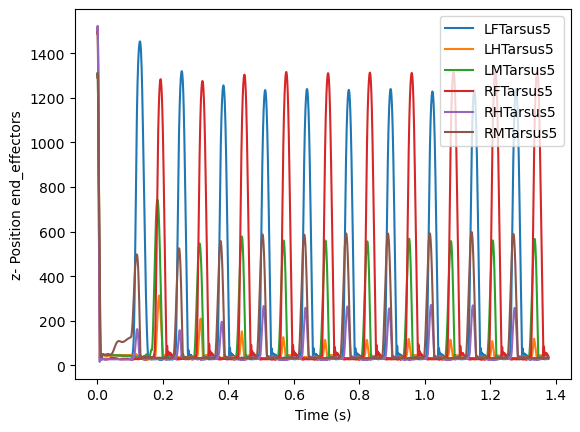

In [19]:
for i, end_effector in enumerate(end_effector_data['z_vals_end_effector_obs']):
    plt.plot(np.arange(len(end_effector)) * nmf.timestep,
        end_effector,
        label=nmf.end_effector_names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('z- Position end_effectors')


Text(0, 0.5, 'y- Position end_effectors')

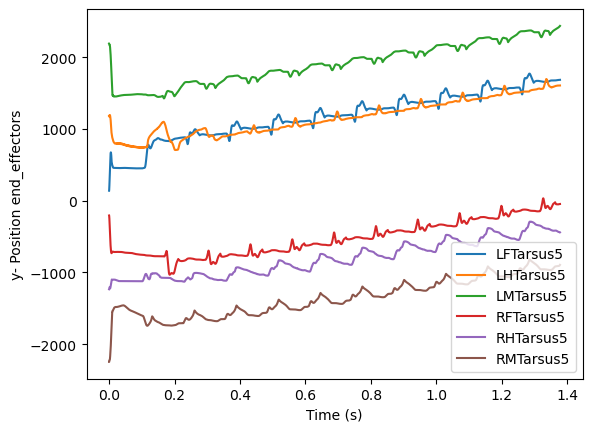

In [20]:
for i, end_effector in enumerate(end_effector_data['y_vals_end_effector_obs']):
    plt.plot(np.arange(len(end_effector)) * nmf.timestep,
        end_effector,
        label=nmf.end_effector_names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('y- Position end_effectors')

Text(0, 0.5, 'x- Position end_effectors')

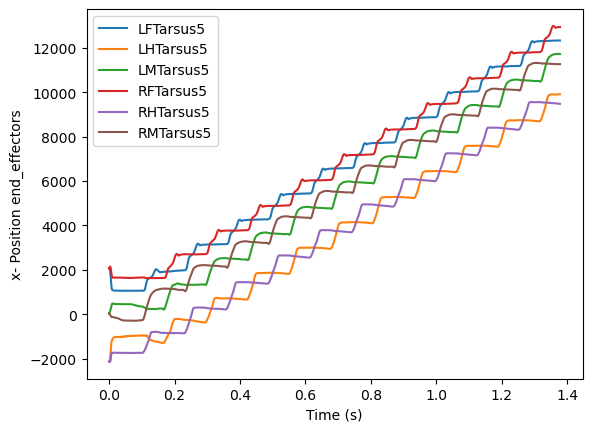

In [21]:
for i, end_effector in enumerate(end_effector_data['x_vals_end_effector_obs']):
    plt.plot(np.arange(len(end_effector)) * nmf.timestep,
        end_effector,
        label=nmf.end_effector_names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('x- Position end_effectors')

In [22]:
nmf.actuated_adhesion_bodies[0]

'LFTarsus5'

In [23]:
np.arange(len(np.array(adhesion_obs)))

array([    0,     1,     2, ..., 13777, 13778, 13779])

Text(0, 0.5, 'adh_val')

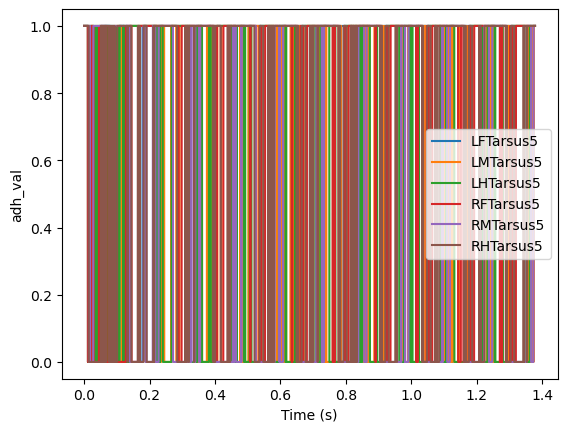

In [24]:
#calculating adhesion
nr_adhesion_bodies = 6
# nr_adhesion_bodies = 6 if "all"
for i in range(nr_adhesion_bodies):
    plt.plot(np.arange(len(adhesion_obs)) * nmf.timestep,
        adhesion_obs[:,i],
        label=nmf.actuated_adhesion_bodies[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('adh_val')

In [25]:
touch_sensor_names = []
for touch_sensors in nmf.touch_sensors:
    touch_sensor_names.append(touch_sensors.name)
print(touch_sensor_names)

['touch_LFTarsus1_collision', 'touch_LFTarsus2_collision', 'touch_LFTarsus3_collision', 'touch_LFTarsus4_collision', 'touch_LFTarsus5_collision', 'touch_LMTarsus1_collision', 'touch_LMTarsus2_collision', 'touch_LMTarsus3_collision', 'touch_LMTarsus4_collision', 'touch_LMTarsus5_collision', 'touch_LHTarsus1_collision', 'touch_LHTarsus2_collision', 'touch_LHTarsus3_collision', 'touch_LHTarsus4_collision', 'touch_LHTarsus5_collision', 'touch_RFTarsus1_collision', 'touch_RFTarsus2_collision', 'touch_RFTarsus3_collision', 'touch_RFTarsus4_collision', 'touch_RFTarsus5_collision', 'touch_RMTarsus1_collision', 'touch_RMTarsus2_collision', 'touch_RMTarsus3_collision', 'touch_RMTarsus4_collision', 'touch_RMTarsus5_collision', 'touch_RHTarsus1_collision', 'touch_RHTarsus2_collision', 'touch_RHTarsus3_collision', 'touch_RHTarsus4_collision', 'touch_RHTarsus5_collision']


In [26]:
touch_sensor_Tarsi5_names = touch_sensor_names[4::5]
print(touch_sensor_Tarsi5_names)

['touch_LFTarsus5_collision', 'touch_LMTarsus5_collision', 'touch_LHTarsus5_collision', 'touch_RFTarsus5_collision', 'touch_RMTarsus5_collision', 'touch_RHTarsus5_collision']


In [27]:
np.shape(np.array(obs_deriv_touch_sensor_Tarsi5))

(13780, 6)

Text(0.5, 1.0, 'contact forces derivative: Tarsus5, normal gravity, no adhesion')

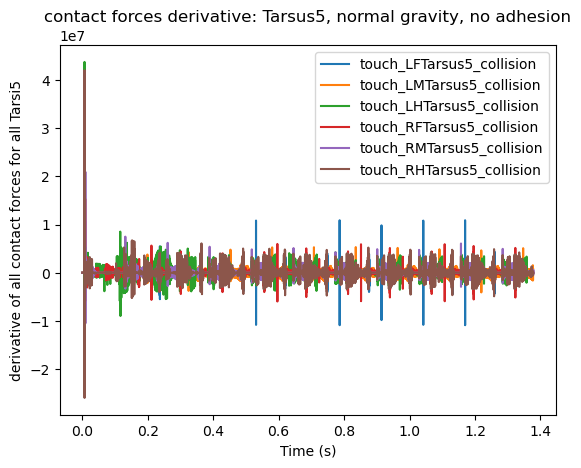

In [28]:
for i in range(nr_adhesion_bodies):
    plt.plot(np.arange(len(obs_deriv_touch_sensor_Tarsi5)) * nmf.timestep,
        np.array(obs_deriv_touch_sensor_Tarsi5)[:,i],
        label=touch_sensor_Tarsi5_names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('derivative of all contact forces for all Tarsi5')
plt.title("contact forces derivative: Tarsus5, normal gravity, no adhesion")

Text(0.5, 0.98, 'before timed adhesion and gravity normal')

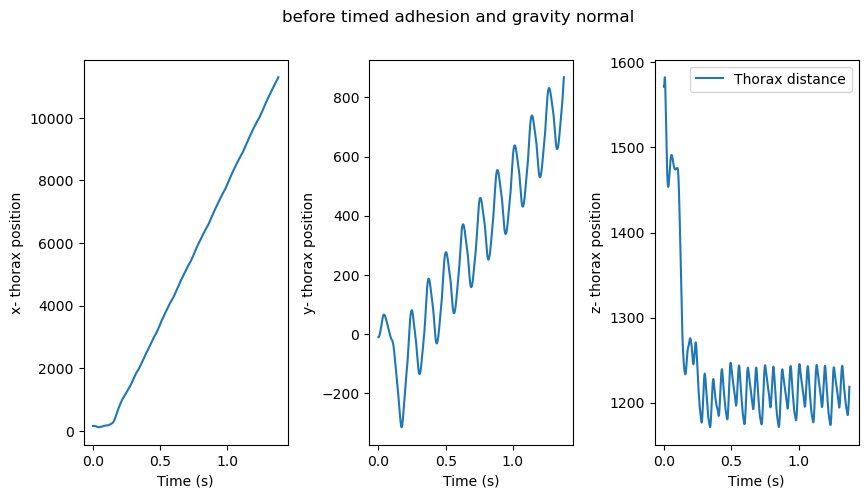

In [29]:
axis = ['x', 'y','z']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

for i, ax in enumerate(axes): 
    #fig.add_subplot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep, 130 + i, [obs['fly'][0][i] for obs in obs_list], label = "Thorax distance", xlabel = "time", ylabel = axis[i] + "thorax position" )
    ax.plot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep,[obs['fly'][0][i] for obs in obs_list], label = "Thorax distance")
    ax.set_ylabel(axis[i]+ "- thorax position")
    ax.set_xlabel('Time (s)')
plt.legend()
plt.subplots_adjust(wspace=0.4)

# plt.ylabel('x- Position end_effectors')
plt.suptitle('before timed adhesion and gravity normal')

Calculating the euclidian distance: 


In [30]:
distance_evolution = np.linalg.norm([obs['fly'][0] - obs_list[0]['fly'][0] for obs in obs_list], axis = 1)

Text(0.5, 0.5, 'final distance: 11182.621622651715')

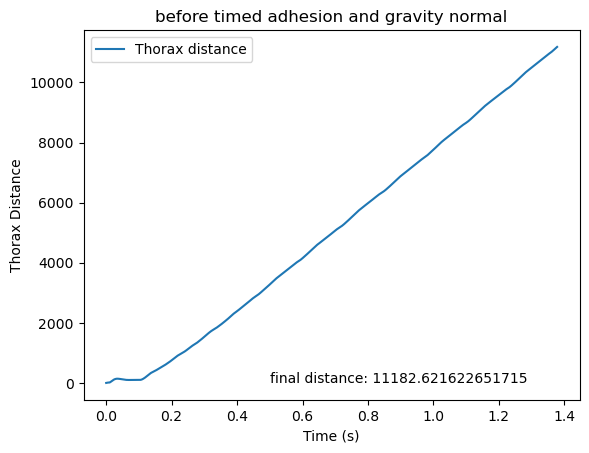

In [31]:
plt.plot(np.arange(np.shape(distance_evolution)[0]) * nmf.timestep,
    distance_evolution,
    label="Thorax distance")
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Thorax Distance')
plt.title('before timed adhesion and gravity normal')
plt.text(0.5, 0.5, f"final distance: {distance_evolution[-1]}")

In [32]:
print(distance_evolution[-1])

11182.621622651715


In [33]:
video_path = Path('PreRunAdhesion_Videos/video_noADH_modifs_MCoxa_45_MHscale1_5_Fscale0_75_left_view_NOADHESION.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

KeyError: 'fps'

# 2nd run: Add Adhesion, Gravity still normal

In [34]:
np.shape(np.array(adhesion_obs))

(13780, 6)

In [35]:
# Run simulation
obs, info = nmf.reset() 
old_obs = obs
obs_list = [obs]
obs_deriv_touch_sensor_Tarsi5 = []
for i in trange(num_steps + n_stabilisation_steps):
    deriv_touch_sensor_Tarsi5 = (obs['contact_forces'][4::5]- old_obs['contact_forces'][4::5])/nmf.timestep
    obs_deriv_touch_sensor_Tarsi5.append(deriv_touch_sensor_Tarsi5)
    """
    if i >= int(num_steps/2):
        #inverting gravity midsimulation
        nmf.physics.model.opt.gravity = (0,0,9.81e5)
    """
    if i < n_stabilisation_steps:
        joint_pos = data_block[:, 0] 
        action = {'joints': joint_pos, 'adhesion': np.array(adhesion_obs)[i,:]} #old version: action = {'joints': joint_pos, 'adhesion': obs['bodies_adhesion']}

    else:
        joint_pos = data_block[:, i-n_stabilisation_steps] #put back i 
        #calculate adhesion
        action = {'joints': joint_pos, 'adhesion': np.array(adhesion_obs)[i,:]} #old version: action = {'joints': joint_pos, 'adhesion': obs['bodies_adhesion']}
    old_obs = obs
    obs, info = nmf.step(action)
    
    nmf.render()
    obs_list.append(obs)

  0%|          | 0/13780 [00:00<?, ?it/s]

100%|██████████| 13780/13780 [00:23<00:00, 596.63it/s]


In [37]:
# Create a list to hold the end effector data len(end_effector_data = 18;)
end_effector_data = [[] for _ in range(18)]

# Iterate through each observation in obs_list
for obs in obs_list:
    end_effectors = obs['end_effectors']

    # Iterate through each value in the end_effectors list and append to the corresponding sublist in end_effector_data
    for i, value in enumerate(end_effectors):
        end_effector_data[i].append(value)

end_effector_data = {'x_vals_end_effector_obs' : end_effector_data[::3], 'y_vals_end_effector_obs': end_effector_data[1::3] , 'z_vals_end_effector_obs': end_effector_data[2::3]}

In [38]:
afterrun_contact = []
for obs in obs_list:
    afterrun_contact.append(obs['contact_forces'][4::5])  

In [39]:
diff = np.array(prerun_contact) - np.array(afterrun_contact)

In [40]:
diff

array([[    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ],
       ...,
       [-3167.17702763,   171.15414932, -1542.20928543, -4053.42083901,
            0.        , -2820.84009805],
       [-3144.75462578,   163.91044003, -1548.31105998, -4056.56111086,
           50.84769792, -2827.44089409],
       [-3121.7072315 ,     0.        , -1555.93183103, -4059.49974233,
            0.        , -2777.93855191]])

Text(0, 0.5, 'z- Position end_effectors')

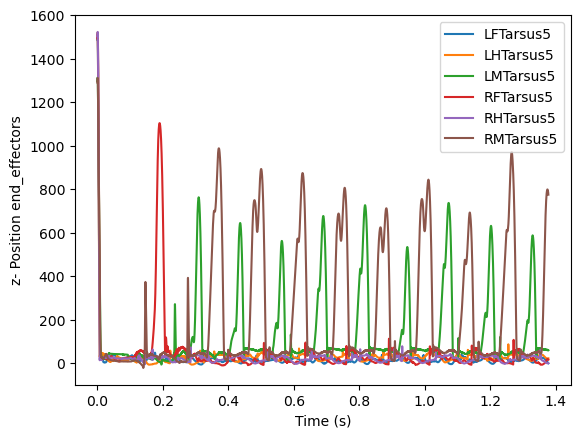

In [41]:
for i, end_effector in enumerate(end_effector_data['z_vals_end_effector_obs']):
    plt.plot(np.arange(len(end_effector)) * nmf.timestep,
        end_effector,
        label=nmf.end_effector_names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('z- Position end_effectors')


Text(0, 0.5, 'x- Position end_effectors')

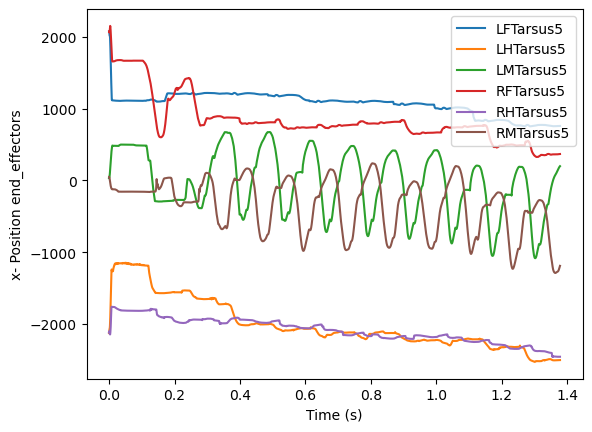

In [42]:
for i, end_effector in enumerate(end_effector_data['x_vals_end_effector_obs']):
    plt.plot(np.arange(len(end_effector)) * nmf.timestep,
        end_effector,
        label=nmf.end_effector_names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('x- Position end_effectors')

Text(0.5, 0.98, 'after timed adhesion and gravity normal')

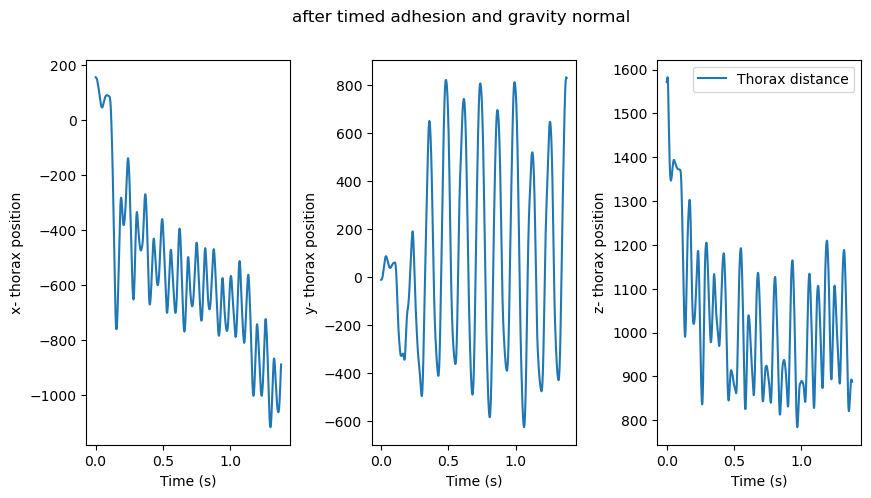

In [43]:
axis = ['x', 'y','z']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

for i, ax in enumerate(axes): 
    #fig.add_subplot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep, 130 + i, [obs['fly'][0][i] for obs in obs_list], label = "Thorax distance", xlabel = "time", ylabel = axis[i] + "thorax position" )
    ax.plot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep,[obs['fly'][0][i] for obs in obs_list], label = "Thorax distance")
    ax.set_ylabel(axis[i]+ "- thorax position")
    ax.set_xlabel('Time (s)')
plt.legend()
plt.subplots_adjust(wspace=0.4)

# plt.ylabel('x- Position end_effectors')
plt.suptitle('after timed adhesion and gravity normal')

Calculating the euclidian distance: 


In [ ]:
distance_evolution = np.linalg.norm([obs['fly'][0] - obs_list[0]['fly'][0] for obs in obs_list], axis = 1)

Text(0.5, 0.5, 'final distance: 1505.9818245452593')

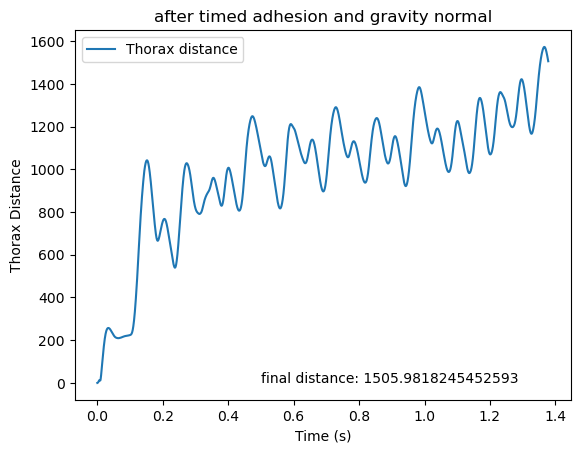

In [ ]:
plt.plot(np.arange(np.shape(distance_evolution)[0]) * nmf.timestep,
    distance_evolution,
    label="Thorax distance")
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Thorax Distance')
plt.title('after timed adhesion and gravity normal')
plt.text(0.5, 0.5, f"final distance: {distance_evolution[-1]}")

In [ ]:
video_path = Path('PreRunAdhesion_Videos/video_noADH_modifs_MCoxa_45_MHscale1_5_Fscale0_75_left_view_ADHESION.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x10\\\x10mdat\x00\…

# 3nd run: Add Adhesion, Gravity inverted 

In [ ]:
# Run simulation
obs, info = nmf.reset() 
nmf.physics.model.opt.gravity = (0,0,9.81e5)
adhesion_gain_multiply = 20
old_obs = obs
obs_list = [obs]
obs_deriv_touch_sensor_Tarsi5 = []
for i in trange(num_steps + n_stabilisation_steps):
    deriv_touch_sensor_Tarsi5 = (obs['contact_forces'][4::5]- old_obs['contact_forces'][4::5])/nmf.timestep
    obs_deriv_touch_sensor_Tarsi5.append(deriv_touch_sensor_Tarsi5)
    """
    if i >= int(num_steps/2):
        #inverting gravity midsimulation
        nmf.physics.model.opt.gravity = (0,0,9.81e5)
    """
    if i < n_stabilisation_steps:
        joint_pos = data_block[:, 0] 
        action = {'joints': joint_pos, 'adhesion': adhesion_gain_multiply*np.array(adhesion_obs)[0,:]}
    else: 

        joint_pos = data_block[:, i-n_stabilisation_steps] #put back i 
        #calculate adhesion
        action = {'joints': joint_pos, 'adhesion': adhesion_gain_multiply*np.array(adhesion_obs)[i,:]} #old version: action = {'joints': joint_pos, 'adhesion': obs['bodies_adhesion']}
    old_obs = obs
    obs, info = nmf.step(action)
    
    nmf.render()
    obs_list.append(obs)

[MJCF Element: <adhesion name="LFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LFTarsus5" gain="2500"/>, MJCF Element: <adhesion name="LMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LMTarsus5" gain="2500"/>, MJCF Element: <adhesion name="LHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="LHTarsus5" gain="2500"/>, MJCF Element: <adhesion name="RFTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RFTarsus5" gain="2500"/>, MJCF Element: <adhesion name="RMTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RMTarsus5" gain="2500"/>, MJCF Element: <adhesion name="RHTarsus5_adhesion" class="/" ctrlrange="0 1000000" forcerange="-inf inf" body="RHTarsus5" gain="2500"/>]


100%|██████████| 13780/13780 [03:20<00:00, 68.75it/s] 


In [ ]:
# Create a list to hold the end effector data len(end_effector_data = 18;)
end_effector_data = [[] for _ in range(18)]

# Iterate through each observation in obs_list
for obs in obs_list:
    end_effectors = obs['end_effectors']

    # Iterate through each value in the end_effectors list and append to the corresponding sublist in end_effector_data
    for i, value in enumerate(end_effectors):
        end_effector_data[i].append(value)

end_effector_data = {'x_vals_end_effector_obs' : end_effector_data[::3], 'y_vals_end_effector_obs': end_effector_data[1::3] , 'z_vals_end_effector_obs': end_effector_data[2::3]}

In [ ]:
afterrun_inv_grav_contact = []
for obs in obs_list:
    afterrun_inv_grav_contact.append(obs['contact_forces'][4::5])  

In [ ]:
diff = np.array(prerun_contact) - np.array(afterrun_inv_grav_contact)

Text(0.5, 1.0, 'after timed adhesion and gravity inverted')

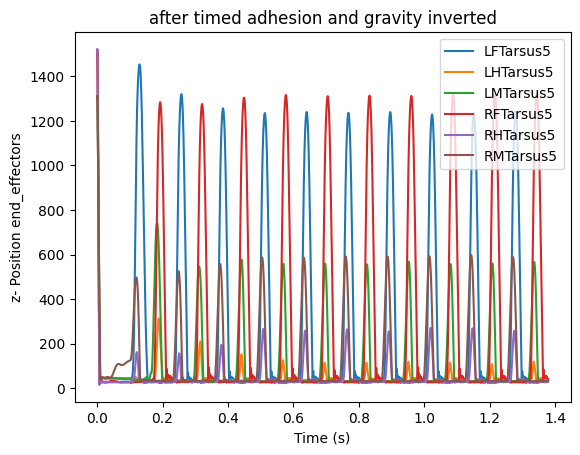

In [ ]:
for i, end_effector in enumerate(end_effector_data['z_vals_end_effector_obs']):
    plt.plot(np.arange(len(end_effector)) * nmf.timestep,
        end_effector,
        label=nmf.end_effector_names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('z- Position end_effectors')
plt.title('after timed adhesion and gravity inverted')

Text(0.5, 1.0, 'after timed adhesion and gravity inverted')

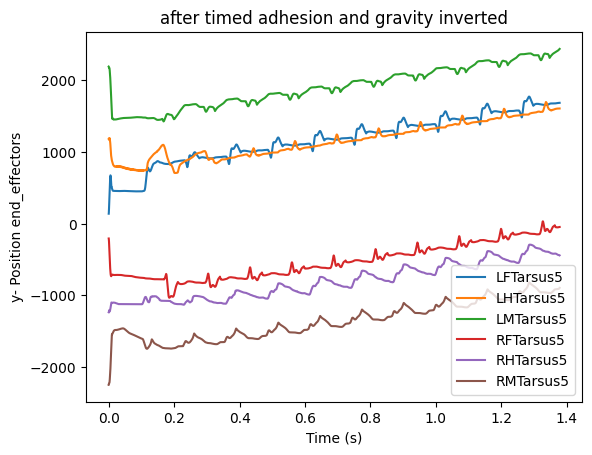

In [ ]:
for i, end_effector in enumerate(end_effector_data['y_vals_end_effector_obs']):
    plt.plot(np.arange(len(end_effector)) * nmf.timestep,
        end_effector,
        label=nmf.end_effector_names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('y- Position end_effectors')
plt.title('after timed adhesion and gravity inverted')

Text(0.5, 1.0, 'after timed adhesion and gravity inverted')

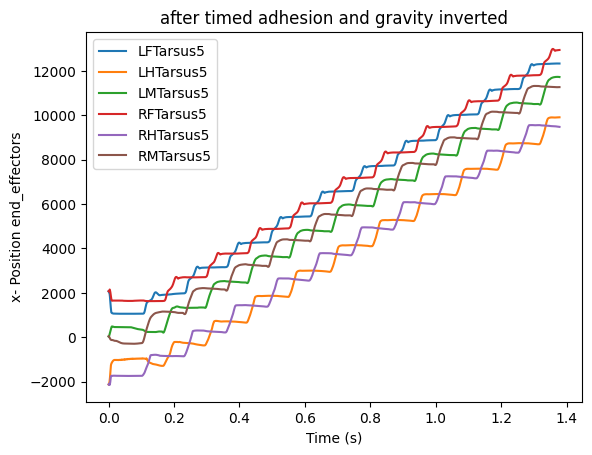

In [ ]:
for i, end_effector in enumerate(end_effector_data['x_vals_end_effector_obs']):
    plt.plot(np.arange(len(end_effector)) * nmf.timestep,
        end_effector,
        label=nmf.end_effector_names[i])
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('x- Position end_effectors')
plt.title('after timed adhesion and gravity inverted')


# Thorax displacement 

Text(0.5, 0.98, 'after timed adhesion and gravity inverted')

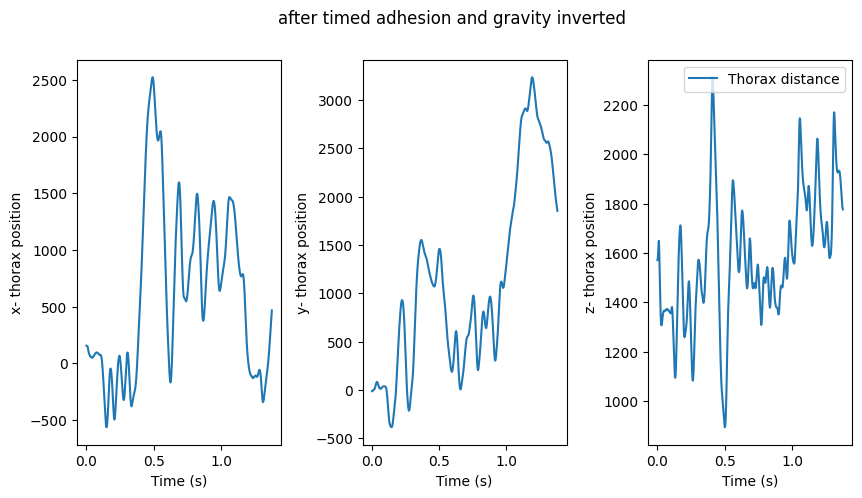

In [ ]:
axis = ['x', 'y','z']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))

for i, ax in enumerate(axes): 
    #fig.add_subplot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep, 130 + i, [obs['fly'][0][i] for obs in obs_list], label = "Thorax distance", xlabel = "time", ylabel = axis[i] + "thorax position" )
    ax.plot(np.arange(len([obs['fly'][0][i] for obs in obs_list])) * nmf.timestep,[obs['fly'][0][i] for obs in obs_list], label = "Thorax distance")
    ax.set_ylabel(axis[i]+ "- thorax position")
    ax.set_xlabel('Time (s)')
plt.legend()
plt.subplots_adjust(wspace=0.4)

# plt.ylabel('x- Position end_effectors')
plt.suptitle('after timed adhesion and gravity inverted')

Calculating the euclidian distance: 


In [ ]:
distance_evolution = np.linalg.norm([obs['fly'][0] - obs_list[0]['fly'][0] for obs in obs_list], axis = 1)

Text(0.5, 0.5, 'final distance: 1902.586379716067')

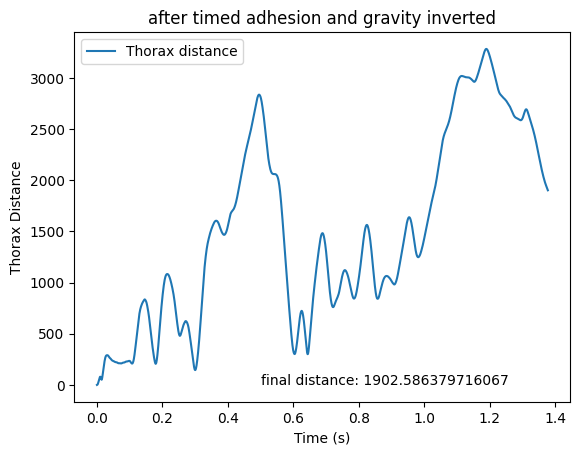

In [ ]:
plt.plot(np.arange(np.shape(distance_evolution)[0]) * nmf.timestep,
    distance_evolution,
    label="Thorax distance")
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Thorax Distance')
plt.title('after timed adhesion and gravity inverted')
plt.text(0.5, 0.5, f"final distance: {distance_evolution[-1]}")

In [ ]:
print(distance_evolution[-1])

1902.586379716067


In [ ]:
video_path = Path('PreRunAdhesion_Videos/video_noADH_modifs_MCoxa_45_MHscale1_5_Fscale0_75_left_view_ADHESION_INVGrav.mp4')
nmf.save_video(video_path)

from ipywidgets import Video
Video.from_file(video_path)

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x15\x9c\xfamdat\x0…